In [53]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# basic functionalities
import re
import os
import sys
import datetime
import itertools
import math 


# data transforamtion and manipulation
import pandas as pd
import pandas_datareader.data as web
import numpy as np
# prevent crazy long pandas prints
pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)
pd.options.mode.chained_assignment = None


# remove warnings
import warnings
warnings.filterwarnings('ignore')


# plotting and plot stying
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn')
#sns.set_style("whitegrid", {'axes.grid' : False})
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"


# statistical modeling libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
#from arch import arch_model


# deep learning
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model 


# jupyter wdgets
from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress
from IPython.display import set_matplotlib_formats, Image


## The model in theory

https://github.com/alberduris/SirajsCodingChallenges/tree/master/Stock%20Market%20Prediction

We are going to use 4 features: The **price** itself and three extra technical indicators.
- MACD (Trend)
- Stochastics (Momentum)
- Average True Range (Volume)


## Feature Engineering

**Exponential Moving Average:** Is a type of infinite impulse response filter that applies weighting factors which decrease exponentially. The weighting for each older datum decreases exponentially, never reaching zero. 
<img src="https://www.bionicturtle.com/images/uploads/WindowsLiveWriterGARCHapproachandExponentialsmoothingEWMA_863image_16.png">

**MACD:**  The Moving Average Convergence/Divergence oscillator (MACD) is one of the simplest and most effective momentum indicators available. The MACD turns two trend-following indicators, moving averages, into a momentum oscillator by subtracting the longer moving average from the shorter moving average.
<img src="http://i68.tinypic.com/289ie1l.png">

**Stochastics oscillator:** The Stochastic Oscillator is a momentum indicator that shows the location of the close relative to the high-low range over a set number of periods.

<img src="http://i66.tinypic.com/2vam3uo.png">

**Average True Range:** Is an indicator to measure the volalitility (NOT price direction). The largest of:
- Method A: Current High less the current Low
- Method B: Current High less the previous Close (absolute value)
- Method C: Current Low less the previous Close (absolute value)

<img src="http://d.stockcharts.com/school/data/media/chart_school/technical_indicators_and_overlays/average_true_range_atr/atr-1-trexam.png" width="400px">

Calculation:
<img src="http://i68.tinypic.com/e0kggi.png">

In [2]:
def MACD(df, period1, period2, periodSignal):
    EMA1 = pd.DataFrame.ewm(df, span=period1).mean()
    EMA2 = pd.DataFrame.ewm(df, span=period2).mean()
    MACD = EMA1 - EMA2
    
    Signal = pd.DataFrame.ewm(MACD, periodSignal).mean()
    
    Histogram = MACD - Signal
    
    return Histogram

def stochastics_oscillator(df, period):
    l, h = pd.DataFrame.rolling(df, period).min(), pd.DataFrame.rolling(df, period).max()
    k = 100 * (df - l) / (h - l)
    return k

def ATR(df,period):
    '''
    Method A: Current High less the current Low
    '''
    df['H-L'] = abs(df['High'] - df['Low'])
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    TR = df[['H-L','H-PC','L-PC']].max(axis=1)
    return TR.to_frame()

In [5]:
df = pd.read_csv('./data/EURUSD.csv',usecols=[1,2,3,4])
df = df.iloc[::-1]
df["Close"] = (df["Close"].str.split()).apply(lambda x: float(x[0].replace(',', '.')))
df["Open"] = (df["Open"].str.split()).apply(lambda x: float(x[0].replace(',', '.')))
df["High"] = (df["High"].str.split()).apply(lambda x: float(x[0].replace(',', '.')))
df["Low"] = (df["Low"].str.split()).apply(lambda x: float(x[0].replace(',', '.')))


dfPrices = pd.read_csv('./data/EURUSD.csv',usecols=[1])
dfPrices = dfPrices.iloc[::-1]
dfPrices["Close"] = (dfPrices["Close"].str.split()).apply(lambda x: float(x[0].replace(',', '.')))

In [6]:
dfPrices.head()

,Close
2629,1.36110
2628,1.35370
2627,1.34260
2626,1.34240
2625,1.34760


# Plotting

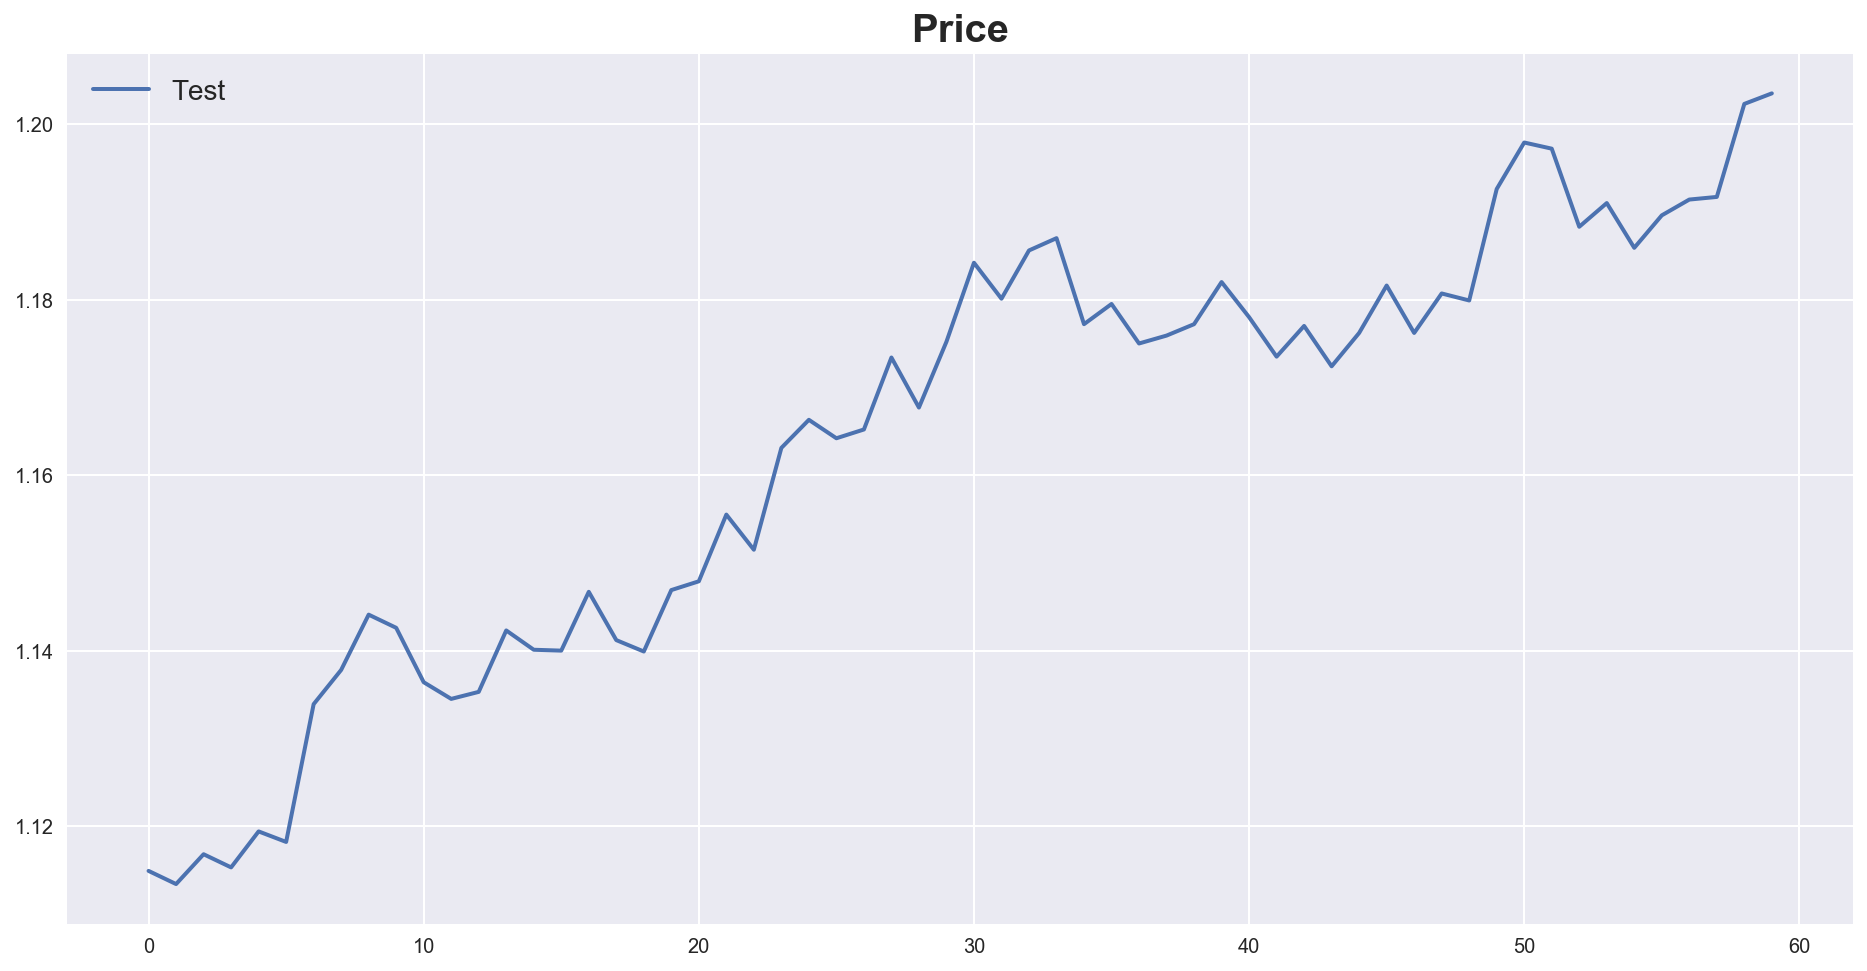

In [11]:
price = dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)].as_matrix().ravel()
prices = dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)].as_matrix().ravel()
plt.figure()
plt.plot(prices,label='Test')
plt.title('Price')
plt.legend(loc='upper left')
plt.show()

### MACD

In [12]:
macd = MACD(dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)],12,26,9)

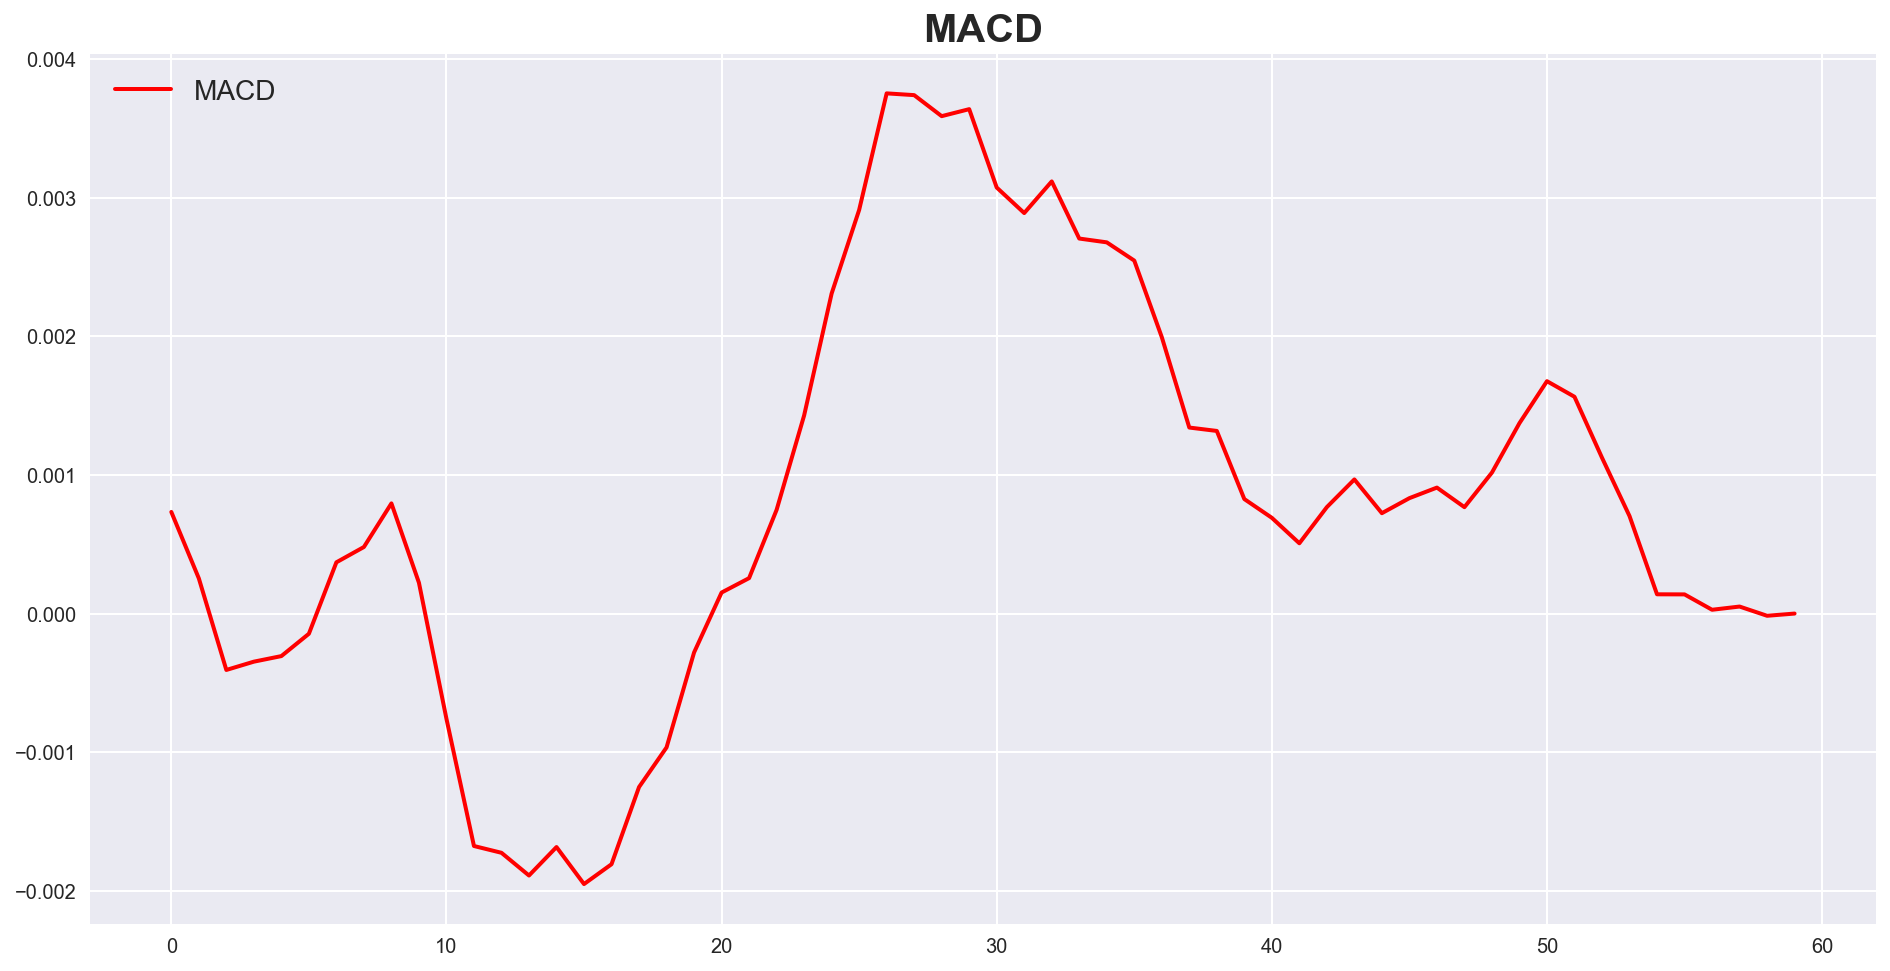

In [13]:
plt.figure()
plt.plot(macd, label='MACD', color='red')
plt.title('MACD')
plt.legend(loc='upper left')
plt.show()

### Stochastics Oscillator

In [14]:
stochastics = stochastics_oscillator(dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)],14)

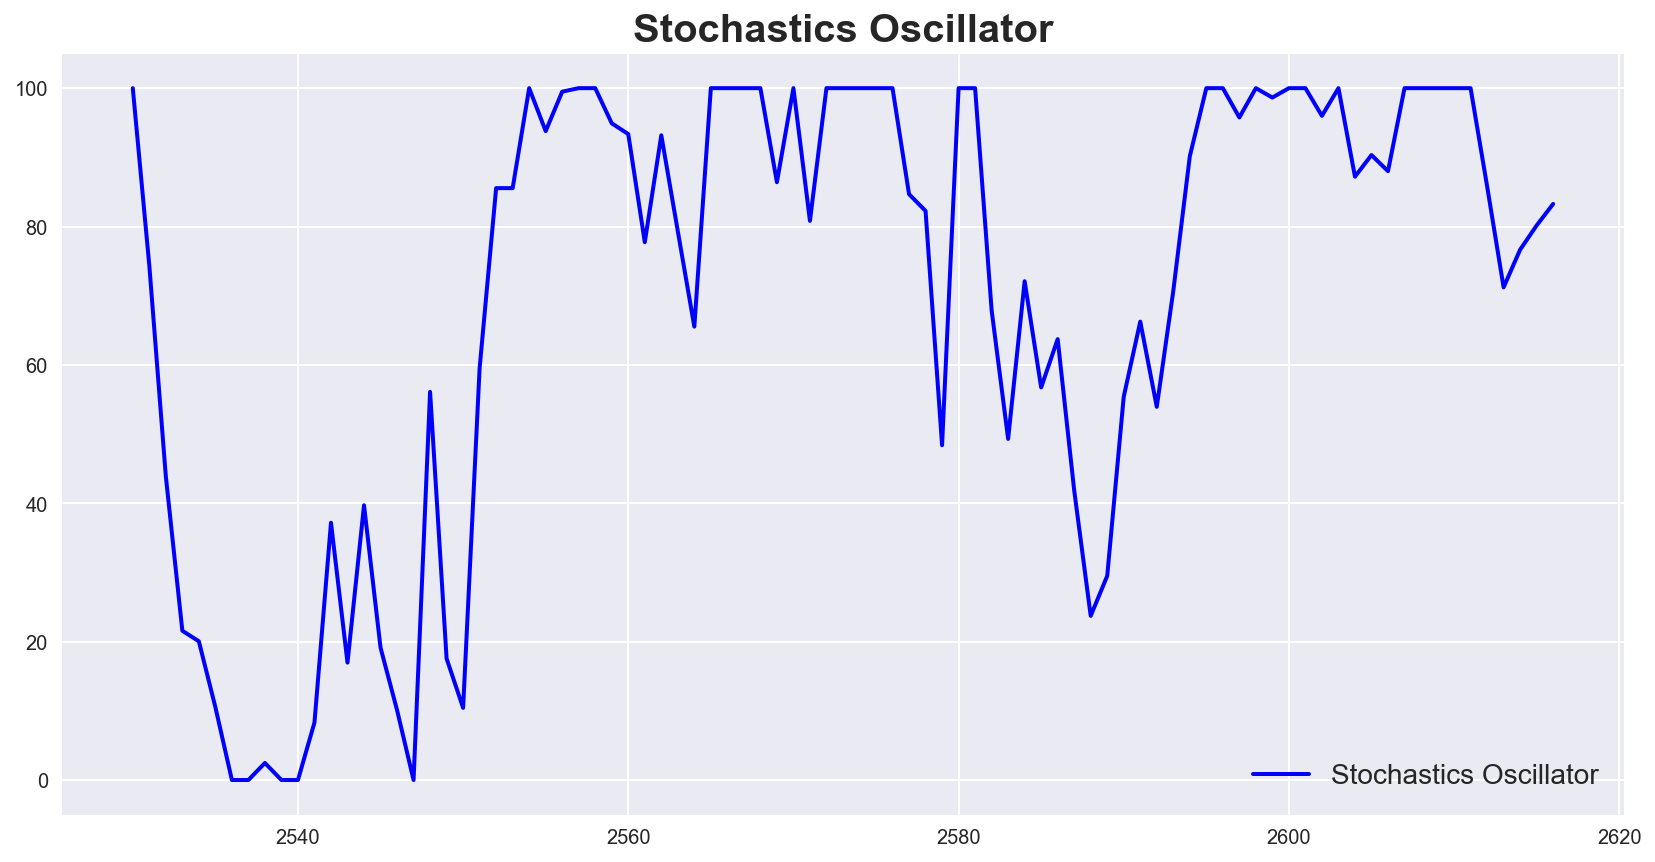

In [24]:
plt.figure(figsize=(14,7))
#First 100 points because it's too dense
plt.plot(stochastics[0:100],label='Stochastics Oscillator',color='blue')
plt.title('Stochastics Oscillator')
plt.legend(loc='best')
plt.show()

### Average True Range

In [16]:
atr = ATR(df.iloc[len(df.index)-60:len(df.index)],14)

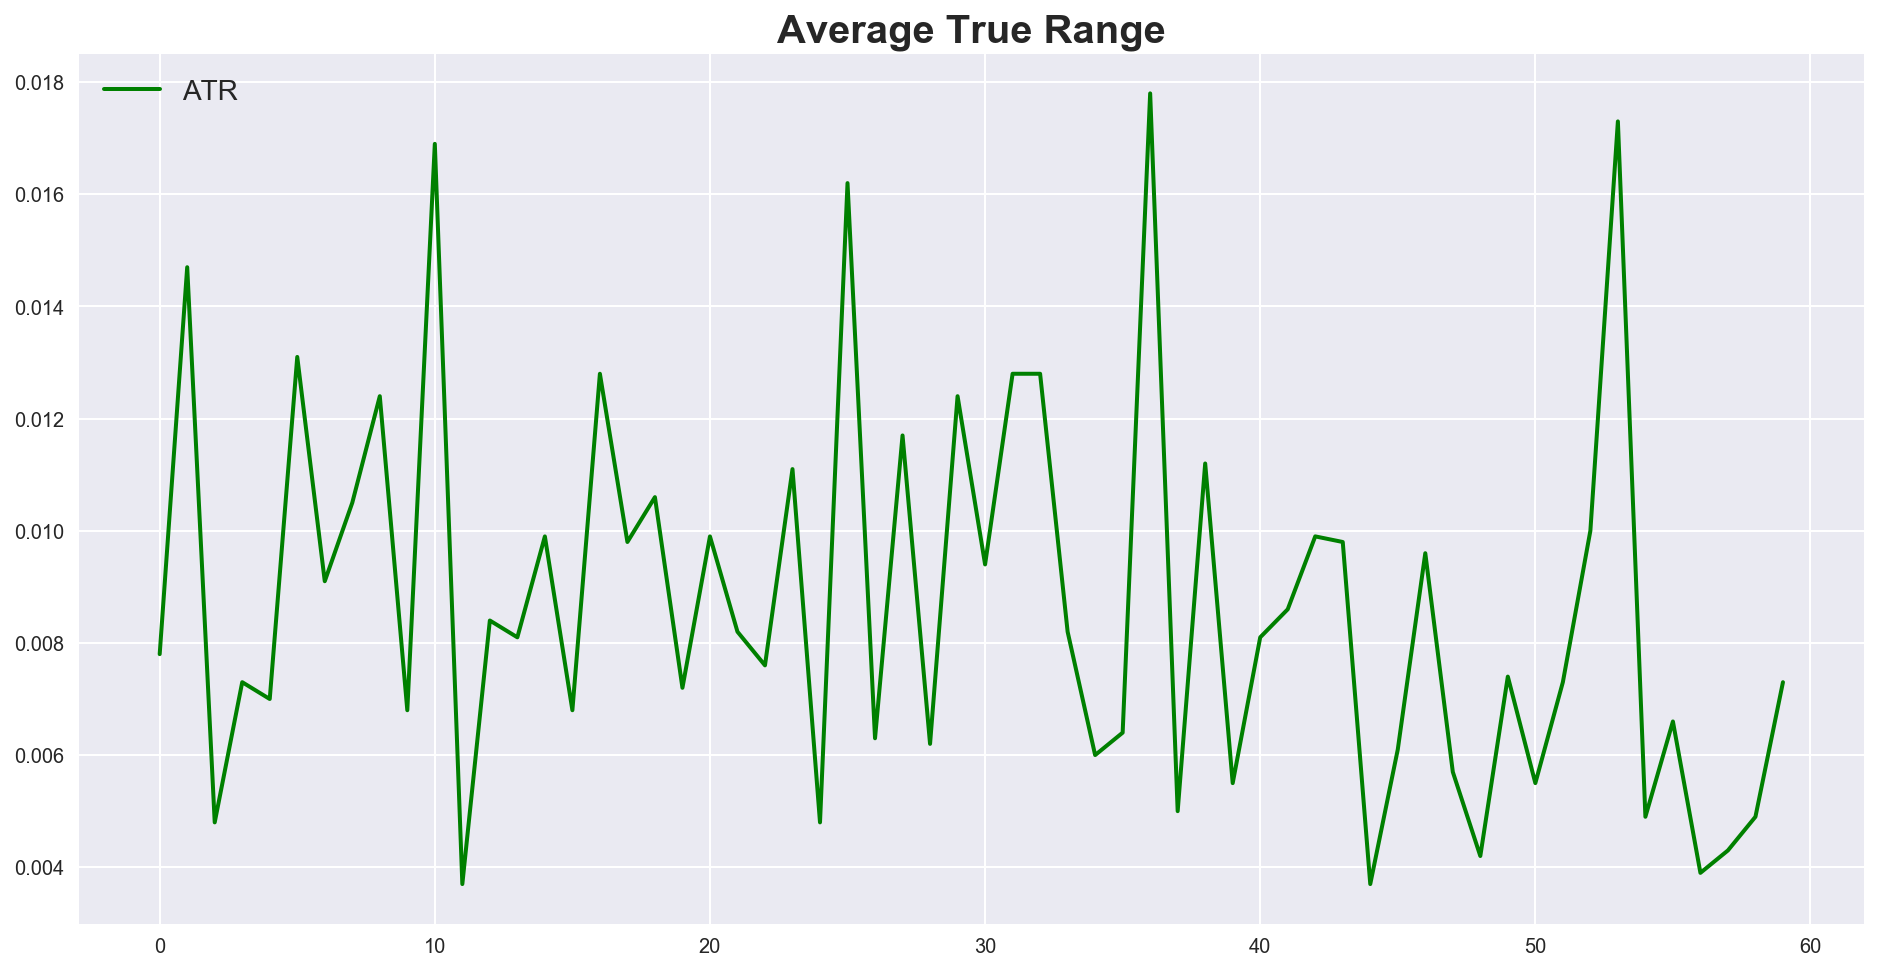

In [17]:
plt.figure()
#First 100 points because it's too dense
plt.plot(atr[0:100], label='ATR', color='green')
plt.title('Average True Range')
plt.legend(loc='upper left')
plt.show()

## Create complete DataFrame & Save Data

In [18]:
dfPriceShift = dfPrices.shift(-1)
dfPriceShift.rename(columns={'Close':'CloseTarget'}, inplace=True)

In [19]:
dfPriceShift.head()

,CloseTarget
2629,1.35370
2628,1.34260
2627,1.34240
2626,1.34760
2625,1.34730


In [20]:
macd = MACD(dfPrices,12,26,9)
macd.rename(columns={'Close':'MACD'}, inplace=True)

stochastics = stochastics_oscillator(dfPrices,14)
stochastics.rename(columns={'Close':'Stochastics'}, inplace=True)

atr = ATR(df,14)
atr.rename(columns={0:'ATR'}, inplace=True)

# concatenate all together
final_data = pd.concat([dfPrices,dfPriceShift,macd,stochastics,atr], axis=1)
# Delete the entries with missing values (where the stochastics couldn't be computed yet) because have a lot of datapoints ;)
final_data = final_data.dropna()

In [21]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2616 entries, 2616 to 1
Data columns (total 5 columns):
Close          2616 non-null float64
CloseTarget    2616 non-null float64
MACD           2616 non-null float64
Stochastics    2616 non-null float64
ATR            2616 non-null float64
dtypes: float64(5)
memory usage: 122.6 KB


In [22]:
final_data

,Close,CloseTarget,MACD,Stochastics,ATR
2616,1.36380,1.36300,0.00132,83.26848,0.00860
2615,1.36300,1.36210,0.00114,80.15564,0.01000
2614,1.36210,1.36070,0.00091,76.65370,0.00530
2613,1.36070,1.36500,0.00064,71.20623,0.00760
2612,1.36500,1.36890,0.00066,85.84475,0.01040
2611,1.36890,1.37680,0.00086,100.00000,0.00760
2610,1.37680,1.37980,0.00140,100.00000,0.01360
2609,1.37980,1.38380,0.00189,100.00000,0.00500
...,...,...,...,...,...
8,1.19720,1.18830,-0.00003,97.25490,0.01240


In [26]:
final_data.to_csv('./data/EURUSD_indicators.csv', index=False)

# Recurrent Neural Network

In [54]:
import tensorflow as tf

In [55]:
dataset = pd.read_csv('./data/EURUSD_indicators.csv')
dataset.head()

,Close,CloseTarget,MACD,Stochastics,ATR
0,1.36380,1.36300,0.00132,83.26848,0.00860
1,1.36300,1.36210,0.00114,80.15564,0.01000
2,1.36210,1.36070,0.00091,76.65370,0.00530
3,1.36070,1.36500,0.00064,71.20623,0.00760
4,1.36500,1.36890,0.00066,85.84475,0.01040


In [56]:
# normalize
datasetNorm = (dataset - dataset.mean()) / (dataset.max() - dataset.min())
datasetNorm.head(2)

,Close,CloseTarget,MACD,Stochastics,ATR
0,0.12130,0.11998,0.02777,0.33638,-0.07637
1,0.11987,0.11837,0.02383,0.30525,-0.04956


In [57]:
# hyperparameters definition
num_epochs = 100

batch_size = 1

total_series_length = len(dataset.index)

truncated_backprop_length = 3 #The size of the sequence

state_size = 12 #The number of neurons

num_features = 4
num_classes = 1 #[1,0]

num_batches = total_series_length // batch_size // truncated_backprop_length

min_test_size = 100

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 2616
The current configuration gives us 872 batches of 1 observations each one looking 3 steps in the past


## Train Test Split

In [58]:
datasetTrain = datasetNorm[dataset.index < num_batches * batch_size * truncated_backprop_length]


for i in range(min_test_size,len(datasetNorm.index)):
    
    if(i % truncated_backprop_length*batch_size == 0):
        test_first_idx = len(datasetNorm.index)-i
        break

datasetTest =  datasetNorm[dataset.index >= test_first_idx]

In [59]:
datasetTrain.head()

,Close,CloseTarget,MACD,Stochastics,ATR
0,0.12130,0.11998,0.02777,0.33638,-0.07637
1,0.11987,0.11837,0.02383,0.30525,-0.04956
2,0.11827,0.11588,0.01904,0.27023,-0.13959
3,0.11577,0.12355,0.01321,0.21575,-0.09553
4,0.12344,0.13052,0.01362,0.36214,-0.04189


In [60]:
datasetTest.head()

,Close,CloseTarget,MACD,Stochastics,ATR
2514,-0.40128,-0.40010,-0.01167,0.34397,-0.16833
2515,-0.40021,-0.39814,-0.00244,0.38563,-0.10511
2516,-0.39825,-0.37332,0.00578,0.46202,-0.13193
2517,-0.37343,-0.36279,0.03266,0.50369,0.15734
2518,-0.36290,-0.36690,0.05952,0.50369,-0.04956


In [61]:
xTrain = datasetTrain[['Close','MACD','Stochastics','ATR']].as_matrix()
yTrain = datasetTrain['CloseTarget'].as_matrix()

In [62]:
print(xTrain[0:3],'\n',yTrain[0:3])

[[ 0.1213   0.02777  0.33638 -0.07637]
 [ 0.11987  0.02383  0.30525 -0.04956]
 [ 0.11827  0.01904  0.27023 -0.13959]] 
 [ 0.11998  0.11837  0.11588]


In [63]:
xTest = datasetTest[['Close','MACD','Stochastics','ATR']].as_matrix()
yTest = datasetTest['CloseTarget'].as_matrix()

In [64]:
print(xTest[0:3],'\n',yTest[0:3])

[[-0.40128 -0.01167  0.34397 -0.16833]
 [-0.40021 -0.00244  0.38563 -0.10511]
 [-0.39825  0.00578  0.46202 -0.13193]] 
 [-0.4001  -0.39814 -0.37332]


## Visualize starting price data

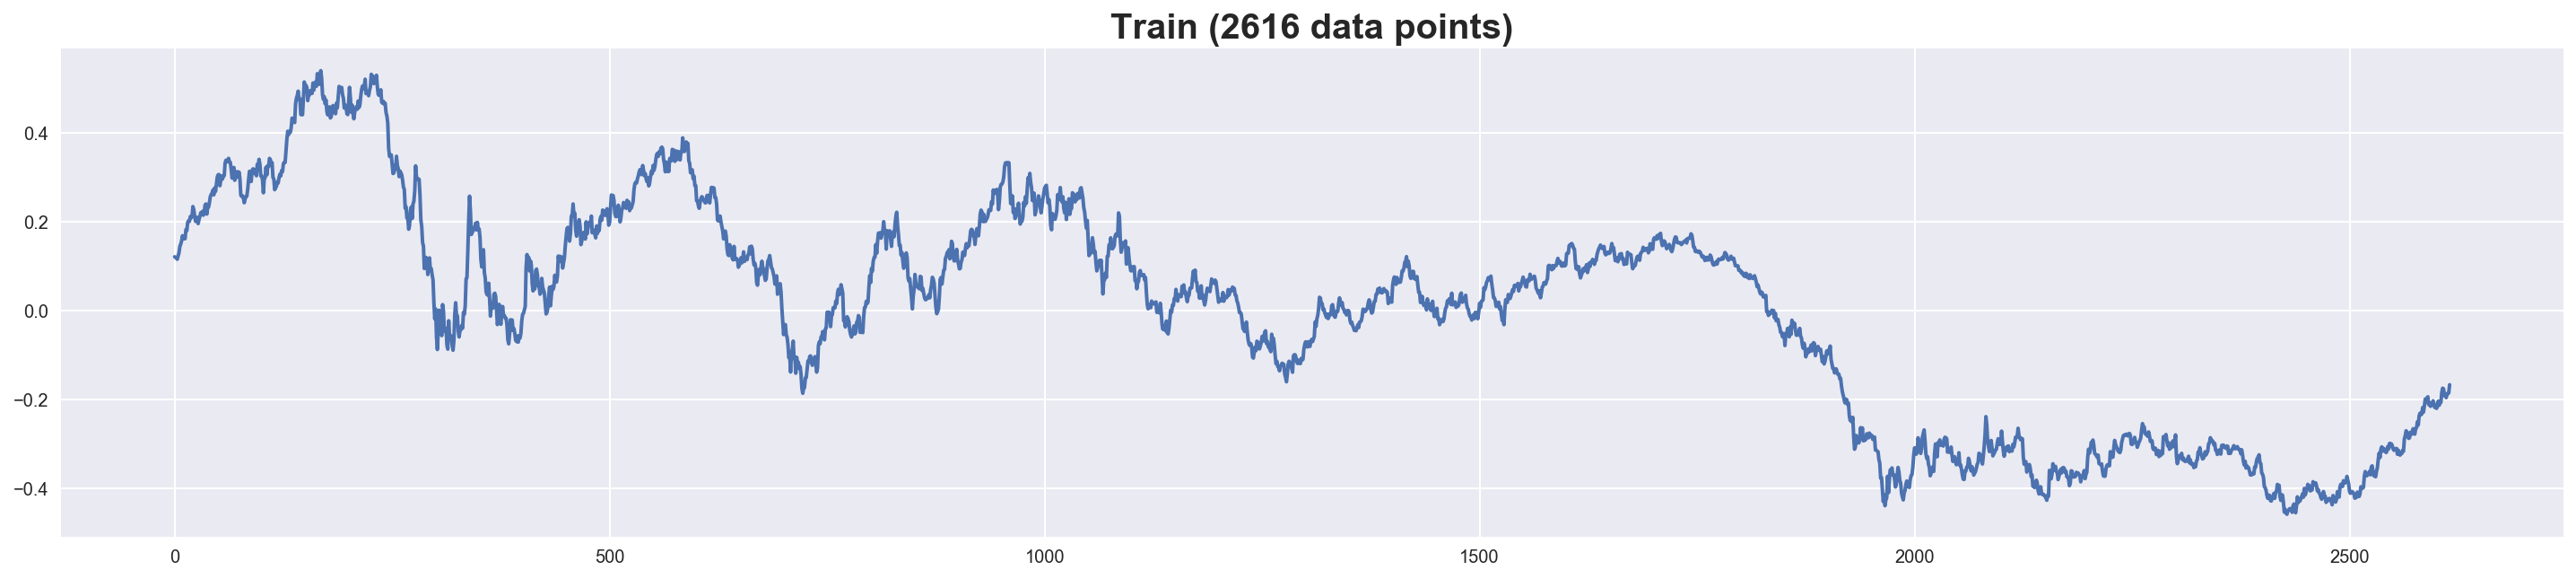

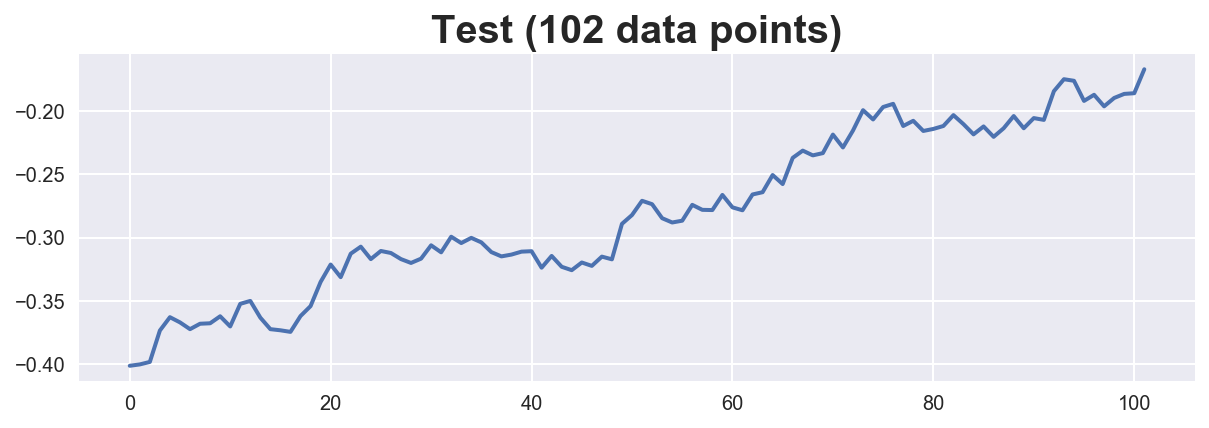

In [65]:
plt.figure(figsize=(25,5))
plt.plot(xTrain[:,0])
plt.title('Train (' +str(len(xTrain))+' data points)')
plt.show()
plt.figure(figsize=(10,3))
plt.plot(xTest[:,0])
plt.title('Test (' +str(len(xTest))+' data points)')
plt.show()

## Placeholders

In [71]:
batchX_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_features],name='data_ph')
batchY_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_classes],name='target_ph')

## Weights and biases
Because is a 3 layer net:
1. Input
2. Hidden Recurrent layer
3. Output

We need 2 pairs of W and b

In [72]:
W2 = tf.Variable(initial_value=np.random.rand(state_size,num_classes),dtype=tf.float32)
b2 = tf.Variable(initial_value=np.random.rand(1,num_classes),dtype=tf.float32)

Unpack

In [73]:
labels_series = tf.unstack(batchY_placeholder, axis=1)

## Forward pass - Unroll the cell

Input to recurrent

In [74]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=state_size)

states_series, current_state = tf.nn.dynamic_rnn(cell=cell,inputs=batchX_placeholder,dtype=tf.float32)

ValueError: Variable rnn/basic_rnn_cell/kernel already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "C:\ProgramData\Anaconda3\envs\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access
  File "C:\ProgramData\Anaconda3\envs\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\ProgramData\Anaconda3\envs\python35\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)


In [70]:
states_series = tf.transpose(states_series,[1,0,2])

## Backward pass - Output

In [47]:
last_state = tf.gather(params=states_series,indices=states_series.get_shape()[0]-1)
last_label = tf.gather(params=labels_series,indices=len(labels_series)-1)

## Weights and bias out

In [48]:
weight = tf.Variable(tf.truncated_normal([state_size,num_classes]))
bias = tf.Variable(tf.constant(0.1,shape=[num_classes]))

## Prediction, Loss & Optimizer

In [50]:
prediction = tf.matmul(last_state,weight) + bias
prediction

<tf.Tensor 'add:0' shape=(?, 1) dtype=float32>

In [51]:
loss = tf.reduce_mean(tf.squared_difference(last_label,prediction))

train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

In [52]:
loss_list = []
test_pred_list = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    for epoch_idx in range(num_epochs):
                
        print('Epoch %d' %epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length * batch_size
        
            
            batchX = xTrain[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
            batchY = yTrain[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
                
            #print('IDXs',start_idx,end_idx)
            #print('X',batchX.shape,batchX)
            #print('Y',batchX.shape,batchY)
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
            #TRAIN!
            _loss,_train_step,_pred,_last_label,_prediction = sess.run(
                fetches=[loss,train_step,prediction,last_label,prediction],
                feed_dict = feed
            )
            
            loss_list.append(_loss)

            
            if(batch_idx % 50 == 0):
                print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                
    #TEST
    
    
    for test_idx in range(len(xTest) - truncated_backprop_length):
        
        testBatchX = xTest[test_idx:test_idx+truncated_backprop_length,:].reshape((1,truncated_backprop_length,num_features))        
        testBatchY = yTest[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,1))

        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY}

        #Test_pred contains 'window_size' predictions, we want the last one
        _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
        test_pred_list.append(test_pred[-1][0]) #The last one

Epoch 0
Step 0 - Loss: 0.142779
Step 50 - Loss: 0.000011
Step 100 - Loss: 0.360689
Step 150 - Loss: 0.002805
Step 200 - Loss: 0.007529
Step 250 - Loss: 0.002375
Step 300 - Loss: 0.004487
Step 350 - Loss: 0.001665
Step 400 - Loss: 0.000382
Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000454
Step 550 - Loss: 0.007366
Step 600 - Loss: 0.000020
Step 650 - Loss: 0.003540
Step 700 - Loss: 0.000932
Step 750 - Loss: 0.001349
Step 800 - Loss: 0.000272
Step 850 - Loss: 0.000058
Epoch 1
Step 0 - Loss: 0.000382
Step 50 - Loss: 0.000008
Step 100 - Loss: 0.008204
Step 150 - Loss: 0.001831
Step 200 - Loss: 0.000006
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000034
Step 400 - Loss: 0.000324
Step 450 - Loss: 0.000881
Step 500 - Loss: 0.000269
Step 550 - Loss: 0.000069
Step 600 - Loss: 0.000056
Step 650 - Loss: 0.000260
Step 700 - Loss: 0.002380
Step 750 - Loss: 0.000003
Step 800 - Loss: 0.001449
Step 850 - Loss: 0.000002
Epoch 2
Step 0 - Loss: 0.000111
Step 50 - Loss: 0.0014

Step 450 - Loss: 0.000221
Step 500 - Loss: 0.000111
Step 550 - Loss: 0.001045
Step 600 - Loss: 0.000047
Step 650 - Loss: 0.000858
Step 700 - Loss: 0.000956
Step 750 - Loss: 0.000040
Step 800 - Loss: 0.000021
Step 850 - Loss: 0.000025
Epoch 18
Step 0 - Loss: 0.001751
Step 50 - Loss: 0.003183
Step 100 - Loss: 0.000033
Step 150 - Loss: 0.000733
Step 200 - Loss: 0.000610
Step 250 - Loss: 0.000332
Step 300 - Loss: 0.000650
Step 350 - Loss: 0.000138
Step 400 - Loss: 0.000011
Step 450 - Loss: 0.000240
Step 500 - Loss: 0.000107
Step 550 - Loss: 0.001019
Step 600 - Loss: 0.000045
Step 650 - Loss: 0.000844
Step 700 - Loss: 0.000935
Step 750 - Loss: 0.000037
Step 800 - Loss: 0.000019
Step 850 - Loss: 0.000026
Epoch 19
Step 0 - Loss: 0.001769
Step 50 - Loss: 0.003113
Step 100 - Loss: 0.000037
Step 150 - Loss: 0.000553
Step 200 - Loss: 0.000631
Step 250 - Loss: 0.000317
Step 300 - Loss: 0.000702
Step 350 - Loss: 0.000097
Step 400 - Loss: 0.000015
Step 450 - Loss: 0.000296
Step 500 - Loss: 0.000105


Step 850 - Loss: 0.000031
Epoch 35
Step 0 - Loss: 0.001078
Step 50 - Loss: 0.002401
Step 100 - Loss: 0.000175
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000412
Step 250 - Loss: 0.000034
Step 300 - Loss: 0.000210
Step 350 - Loss: 0.000012
Step 400 - Loss: 0.000026
Step 450 - Loss: 0.000336
Step 500 - Loss: 0.000122
Step 550 - Loss: 0.000535
Step 600 - Loss: 0.000036
Step 650 - Loss: 0.000573
Step 700 - Loss: 0.000803
Step 750 - Loss: 0.000060
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000031
Epoch 36
Step 0 - Loss: 0.001036
Step 50 - Loss: 0.002370
Step 100 - Loss: 0.000185
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000397
Step 250 - Loss: 0.000027
Step 300 - Loss: 0.000189
Step 350 - Loss: 0.000013
Step 400 - Loss: 0.000024
Step 450 - Loss: 0.000335
Step 500 - Loss: 0.000122
Step 550 - Loss: 0.000514
Step 600 - Loss: 0.000036
Step 650 - Loss: 0.000555
Step 700 - Loss: 0.000823
Step 750 - Loss: 0.000060
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000030
Epoch 37
Step 0 - Loss: 0.

Step 400 - Loss: 0.000003
Step 450 - Loss: 0.000314
Step 500 - Loss: 0.000133
Step 550 - Loss: 0.000298
Step 600 - Loss: 0.000033
Step 650 - Loss: 0.000296
Step 700 - Loss: 0.001026
Step 750 - Loss: 0.000045
Step 800 - Loss: 0.000003
Step 850 - Loss: 0.000029
Epoch 53
Step 0 - Loss: 0.000885
Step 50 - Loss: 0.001961
Step 100 - Loss: 0.000533
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000226
Step 250 - Loss: 0.000004
Step 300 - Loss: 0.000175
Step 350 - Loss: 0.000025
Step 400 - Loss: 0.000003
Step 450 - Loss: 0.000319
Step 500 - Loss: 0.000132
Step 550 - Loss: 0.000289
Step 600 - Loss: 0.000034
Step 650 - Loss: 0.000284
Step 700 - Loss: 0.001029
Step 750 - Loss: 0.000044
Step 800 - Loss: 0.000004
Step 850 - Loss: 0.000029
Epoch 54
Step 0 - Loss: 0.000889
Step 50 - Loss: 0.001938
Step 100 - Loss: 0.000561
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000220
Step 250 - Loss: 0.000006
Step 300 - Loss: 0.000180
Step 350 - Loss: 0.000027
Step 400 - Loss: 0.000003
Step 450 - Loss: 0.000325


Step 750 - Loss: 0.000042
Step 800 - Loss: 0.000008
Step 850 - Loss: 0.000032
Epoch 70
Step 0 - Loss: 0.000802
Step 50 - Loss: 0.001724
Step 100 - Loss: 0.000994
Step 150 - Loss: 0.000045
Step 200 - Loss: 0.000119
Step 250 - Loss: 0.000020
Step 300 - Loss: 0.000120
Step 350 - Loss: 0.000044
Step 400 - Loss: 0.000001
Step 450 - Loss: 0.000398
Step 500 - Loss: 0.000086
Step 550 - Loss: 0.000225
Step 600 - Loss: 0.000043
Step 650 - Loss: 0.000193
Step 700 - Loss: 0.000959
Step 750 - Loss: 0.000042
Step 800 - Loss: 0.000008
Step 850 - Loss: 0.000032
Epoch 71
Step 0 - Loss: 0.000789
Step 50 - Loss: 0.001713
Step 100 - Loss: 0.001018
Step 150 - Loss: 0.000049
Step 200 - Loss: 0.000113
Step 250 - Loss: 0.000018
Step 300 - Loss: 0.000115
Step 350 - Loss: 0.000044
Step 400 - Loss: 0.000001
Step 450 - Loss: 0.000391
Step 500 - Loss: 0.000084
Step 550 - Loss: 0.000224
Step 600 - Loss: 0.000043
Step 650 - Loss: 0.000190
Step 700 - Loss: 0.000954
Step 750 - Loss: 0.000042
Step 800 - Loss: 0.000009


Step 100 - Loss: 0.001488
Step 150 - Loss: 0.000146
Step 200 - Loss: 0.000146
Step 250 - Loss: 0.000000
Step 300 - Loss: 0.000093
Step 350 - Loss: 0.000042
Step 400 - Loss: 0.000000
Step 450 - Loss: 0.000230
Step 500 - Loss: 0.000051
Step 550 - Loss: 0.000228
Step 600 - Loss: 0.000051
Step 650 - Loss: 0.000168
Step 700 - Loss: 0.000829
Step 750 - Loss: 0.000047
Step 800 - Loss: 0.000020
Step 850 - Loss: 0.000049
Epoch 88
Step 0 - Loss: 0.000587
Step 50 - Loss: 0.001469
Step 100 - Loss: 0.001494
Step 150 - Loss: 0.000127
Step 200 - Loss: 0.000227
Step 250 - Loss: 0.000001
Step 300 - Loss: 0.000153
Step 350 - Loss: 0.000033
Step 400 - Loss: 0.000001
Step 450 - Loss: 0.000250
Step 500 - Loss: 0.000050
Step 550 - Loss: 0.000229
Step 600 - Loss: 0.000051
Step 650 - Loss: 0.000157
Step 700 - Loss: 0.000830
Step 750 - Loss: 0.000050
Step 800 - Loss: 0.000021
Step 850 - Loss: 0.000055
Epoch 89
Step 0 - Loss: 0.000620
Step 50 - Loss: 0.001413
Step 100 - Loss: 0.001558
Step 150 - Loss: 0.000162


Step 350 - Loss: 0.000026
Step 400 - Loss: 0.000000
Step 450 - Loss: 0.000227
Step 500 - Loss: 0.000018
Step 550 - Loss: 0.000238
Step 600 - Loss: 0.000059
Step 650 - Loss: 0.000147
Step 700 - Loss: 0.000583
Step 750 - Loss: 0.000055
Step 800 - Loss: 0.000042
Step 850 - Loss: 0.000083
Epoch 105
Step 0 - Loss: 0.000491
Step 50 - Loss: 0.001268
Step 100 - Loss: 0.001949
Step 150 - Loss: 0.000277
Step 200 - Loss: 0.000206
Step 250 - Loss: 0.000023
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000031
Step 400 - Loss: 0.000000
Step 450 - Loss: 0.000218
Step 500 - Loss: 0.000015
Step 550 - Loss: 0.000235
Step 600 - Loss: 0.000059
Step 650 - Loss: 0.000137
Step 700 - Loss: 0.000575
Step 750 - Loss: 0.000053
Step 800 - Loss: 0.000042
Step 850 - Loss: 0.000082
Epoch 106
Step 0 - Loss: 0.000468
Step 50 - Loss: 0.001265
Step 100 - Loss: 0.001921
Step 150 - Loss: 0.000261
Step 200 - Loss: 0.000192
Step 250 - Loss: 0.000018
Step 300 - Loss: 0.000090
Step 350 - Loss: 0.000025
Step 400 - Loss: 0.00000

Step 800 - Loss: 0.000059
Step 850 - Loss: 0.000108
Epoch 122
Step 0 - Loss: 0.000404
Step 50 - Loss: 0.001136
Step 100 - Loss: 0.002181
Step 150 - Loss: 0.000302
Step 200 - Loss: 0.000156
Step 250 - Loss: 0.000040
Step 300 - Loss: 0.000067
Step 350 - Loss: 0.000029
Step 400 - Loss: 0.000000
Step 450 - Loss: 0.000227
Step 500 - Loss: 0.000004
Step 550 - Loss: 0.000226
Step 600 - Loss: 0.000058
Step 650 - Loss: 0.000137
Step 700 - Loss: 0.000409
Step 750 - Loss: 0.000052
Step 800 - Loss: 0.000061
Step 850 - Loss: 0.000107
Epoch 123
Step 0 - Loss: 0.000394
Step 50 - Loss: 0.001181
Step 100 - Loss: 0.002160
Step 150 - Loss: 0.000297
Step 200 - Loss: 0.000194
Step 250 - Loss: 0.000038
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000023
Step 400 - Loss: 0.000001
Step 450 - Loss: 0.000230
Step 500 - Loss: 0.000003
Step 550 - Loss: 0.000221
Step 600 - Loss: 0.000060
Step 650 - Loss: 0.000138
Step 700 - Loss: 0.000430
Step 750 - Loss: 0.000056
Step 800 - Loss: 0.000061
Step 850 - Loss: 0.00010

Step 200 - Loss: 0.000158
Step 250 - Loss: 0.000040
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000038
Step 400 - Loss: 0.000002
Step 450 - Loss: 0.000222
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000191
Step 600 - Loss: 0.000063
Step 650 - Loss: 0.000136
Step 700 - Loss: 0.000379
Step 750 - Loss: 0.000060
Step 800 - Loss: 0.000071
Step 850 - Loss: 0.000118
Epoch 140
Step 0 - Loss: 0.000341
Step 50 - Loss: 0.001195
Step 100 - Loss: 0.002217
Step 150 - Loss: 0.000277
Step 200 - Loss: 0.000148
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000065
Step 350 - Loss: 0.000043
Step 400 - Loss: 0.000002
Step 450 - Loss: 0.000222
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000186
Step 600 - Loss: 0.000062
Step 650 - Loss: 0.000132
Step 700 - Loss: 0.000362
Step 750 - Loss: 0.000057
Step 800 - Loss: 0.000070
Step 850 - Loss: 0.000117
Epoch 141
Step 0 - Loss: 0.000328
Step 50 - Loss: 0.001071
Step 100 - Loss: 0.002286
Step 150 - Loss: 0.000270
Step 200 - Loss: 0.000171
Step 250 - Loss: 0.00004

Step 650 - Loss: 0.000125
Step 700 - Loss: 0.000316
Step 750 - Loss: 0.000067
Step 800 - Loss: 0.000072
Step 850 - Loss: 0.000109
Epoch 157
Step 0 - Loss: 0.000246
Step 50 - Loss: 0.000908
Step 100 - Loss: 0.002286
Step 150 - Loss: 0.000218
Step 200 - Loss: 0.000151
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000095
Step 400 - Loss: 0.000004
Step 450 - Loss: 0.000193
Step 500 - Loss: 0.000002
Step 550 - Loss: 0.000166
Step 600 - Loss: 0.000061
Step 650 - Loss: 0.000138
Step 700 - Loss: 0.000329
Step 750 - Loss: 0.000066
Step 800 - Loss: 0.000074
Step 850 - Loss: 0.000112
Epoch 158
Step 0 - Loss: 0.000251
Step 50 - Loss: 0.000969
Step 100 - Loss: 0.002327
Step 150 - Loss: 0.000249
Step 200 - Loss: 0.000143
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000062
Step 350 - Loss: 0.000097
Step 400 - Loss: 0.000005
Step 450 - Loss: 0.000198
Step 500 - Loss: 0.000002
Step 550 - Loss: 0.000168
Step 600 - Loss: 0.000061
Step 650 - Loss: 0.000127
Step 700 - Loss: 0.00030

Step 100 - Loss: 0.001981
Step 150 - Loss: 0.000278
Step 200 - Loss: 0.000172
Step 250 - Loss: 0.000089
Step 300 - Loss: 0.000048
Step 350 - Loss: 0.000141
Step 400 - Loss: 0.000013
Step 450 - Loss: 0.000181
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000186
Step 600 - Loss: 0.000058
Step 650 - Loss: 0.000092
Step 700 - Loss: 0.000288
Step 750 - Loss: 0.000087
Step 800 - Loss: 0.000077
Step 850 - Loss: 0.000104
Epoch 175
Step 0 - Loss: 0.000204
Step 50 - Loss: 0.000642
Step 100 - Loss: 0.002190
Step 150 - Loss: 0.000164
Step 200 - Loss: 0.000141
Step 250 - Loss: 0.000081
Step 300 - Loss: 0.000050
Step 350 - Loss: 0.000139
Step 400 - Loss: 0.000012
Step 450 - Loss: 0.000174
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000157
Step 600 - Loss: 0.000059
Step 650 - Loss: 0.000096
Step 700 - Loss: 0.000251
Step 750 - Loss: 0.000095
Step 800 - Loss: 0.000070
Step 850 - Loss: 0.000097
Epoch 176
Step 0 - Loss: 0.000191
Step 50 - Loss: 0.000939
Step 100 - Loss: 0.002279
Step 150 - Loss: 0.00019

Step 400 - Loss: 0.000016
Step 450 - Loss: 0.000156
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000168
Step 600 - Loss: 0.000056
Step 650 - Loss: 0.000106
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000103
Step 800 - Loss: 0.000070
Step 850 - Loss: 0.000097
Epoch 192
Step 0 - Loss: 0.000161
Step 50 - Loss: 0.000799
Step 100 - Loss: 0.002176
Step 150 - Loss: 0.000150
Step 200 - Loss: 0.000115
Step 250 - Loss: 0.000097
Step 300 - Loss: 0.000042
Step 350 - Loss: 0.000165
Step 400 - Loss: 0.000014
Step 450 - Loss: 0.000161
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000153
Step 600 - Loss: 0.000057
Step 650 - Loss: 0.000109
Step 700 - Loss: 0.000290
Step 750 - Loss: 0.000091
Step 800 - Loss: 0.000073
Step 850 - Loss: 0.000099
Epoch 193
Step 0 - Loss: 0.000176
Step 50 - Loss: 0.000768
Step 100 - Loss: 0.002110
Step 150 - Loss: 0.000177
Step 200 - Loss: 0.000145
Step 250 - Loss: 0.000103
Step 300 - Loss: 0.000041
Step 350 - Loss: 0.000167
Step 400 - Loss: 0.000015
Step 450 - Loss: 0.00016

Step 800 - Loss: 0.000070
Step 850 - Loss: 0.000100
Epoch 209
Step 0 - Loss: 0.000157
Step 50 - Loss: 0.000697
Step 100 - Loss: 0.002051
Step 150 - Loss: 0.000117
Step 200 - Loss: 0.000154
Step 250 - Loss: 0.000112
Step 300 - Loss: 0.000042
Step 350 - Loss: 0.000189
Step 400 - Loss: 0.000018
Step 450 - Loss: 0.000155
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000157
Step 600 - Loss: 0.000054
Step 650 - Loss: 0.000083
Step 700 - Loss: 0.000262
Step 750 - Loss: 0.000112
Step 800 - Loss: 0.000074
Step 850 - Loss: 0.000102
Epoch 210
Step 0 - Loss: 0.000152
Step 50 - Loss: 0.000730
Step 100 - Loss: 0.002058
Step 150 - Loss: 0.000132
Step 200 - Loss: 0.000149
Step 250 - Loss: 0.000100
Step 300 - Loss: 0.000044
Step 350 - Loss: 0.000188
Step 400 - Loss: 0.000016
Step 450 - Loss: 0.000149
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000155
Step 600 - Loss: 0.000052
Step 650 - Loss: 0.000089
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000110
Step 800 - Loss: 0.000070
Step 850 - Loss: 0.00010

Step 150 - Loss: 0.000138
Step 200 - Loss: 0.000147
Step 250 - Loss: 0.000109
Step 300 - Loss: 0.000042
Step 350 - Loss: 0.000194
Step 400 - Loss: 0.000020
Step 450 - Loss: 0.000151
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000052
Step 650 - Loss: 0.000075
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000116
Step 800 - Loss: 0.000072
Step 850 - Loss: 0.000103
Epoch 227
Step 0 - Loss: 0.000143
Step 50 - Loss: 0.000555
Step 100 - Loss: 0.002060
Step 150 - Loss: 0.000116
Step 200 - Loss: 0.000153
Step 250 - Loss: 0.000105
Step 300 - Loss: 0.000044
Step 350 - Loss: 0.000198
Step 400 - Loss: 0.000019
Step 450 - Loss: 0.000143
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000051
Step 650 - Loss: 0.000088
Step 700 - Loss: 0.000226
Step 750 - Loss: 0.000117
Step 800 - Loss: 0.000068
Step 850 - Loss: 0.000101
Epoch 228
Step 0 - Loss: 0.000138
Step 50 - Loss: 0.000551
Step 100 - Loss: 0.002113
Step 150 - Loss: 0.000118
Step 200 - Loss: 0.00014

Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000050
Step 650 - Loss: 0.000081
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000111
Step 800 - Loss: 0.000072
Step 850 - Loss: 0.000102
Epoch 244
Step 0 - Loss: 0.000127
Step 50 - Loss: 0.000530
Step 100 - Loss: 0.002111
Step 150 - Loss: 0.000106
Step 200 - Loss: 0.000165
Step 250 - Loss: 0.000106
Step 300 - Loss: 0.000044
Step 350 - Loss: 0.000193
Step 400 - Loss: 0.000021
Step 450 - Loss: 0.000147
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000051
Step 650 - Loss: 0.000074
Step 700 - Loss: 0.000226
Step 750 - Loss: 0.000115
Step 800 - Loss: 0.000074
Step 850 - Loss: 0.000106
Epoch 245
Step 0 - Loss: 0.000124
Step 50 - Loss: 0.000587
Step 100 - Loss: 0.002164
Step 150 - Loss: 0.000115
Step 200 - Loss: 0.000167
Step 250 - Loss: 0.000111
Step 300 - Loss: 0.000043
Step 350 - Loss: 0.000196
Step 400 - Loss: 0.000023
Step 450 - Loss: 0.000151
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000153
Step 600 - Loss: 0.00005

Step 850 - Loss: 0.000106
Epoch 261
Step 0 - Loss: 0.000116
Step 50 - Loss: 0.000468
Step 100 - Loss: 0.002169
Step 150 - Loss: 0.000088
Step 200 - Loss: 0.000177
Step 250 - Loss: 0.000117
Step 300 - Loss: 0.000043
Step 350 - Loss: 0.000200
Step 400 - Loss: 0.000021
Step 450 - Loss: 0.000141
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000139
Step 600 - Loss: 0.000049
Step 650 - Loss: 0.000074
Step 700 - Loss: 0.000219
Step 750 - Loss: 0.000121
Step 800 - Loss: 0.000079
Step 850 - Loss: 0.000111
Epoch 262
Step 0 - Loss: 0.000106
Step 50 - Loss: 0.000561
Step 100 - Loss: 0.002228
Step 150 - Loss: 0.000109
Step 200 - Loss: 0.000179
Step 250 - Loss: 0.000115
Step 300 - Loss: 0.000042
Step 350 - Loss: 0.000196
Step 400 - Loss: 0.000022
Step 450 - Loss: 0.000145
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000140
Step 600 - Loss: 0.000050
Step 650 - Loss: 0.000071
Step 700 - Loss: 0.000198
Step 750 - Loss: 0.000127
Step 800 - Loss: 0.000072
Step 850 - Loss: 0.000109
Epoch 263
Step 0 - Loss:

Step 400 - Loss: 0.000022
Step 450 - Loss: 0.000143
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000129
Step 600 - Loss: 0.000049
Step 650 - Loss: 0.000077
Step 700 - Loss: 0.000210
Step 750 - Loss: 0.000124
Step 800 - Loss: 0.000077
Step 850 - Loss: 0.000112
Epoch 279
Step 0 - Loss: 0.000100
Step 50 - Loss: 0.000534
Step 100 - Loss: 0.002235
Step 150 - Loss: 0.000107
Step 200 - Loss: 0.000195
Step 250 - Loss: 0.000125
Step 300 - Loss: 0.000042
Step 350 - Loss: 0.000203
Step 400 - Loss: 0.000026
Step 450 - Loss: 0.000153
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000049
Step 650 - Loss: 0.000067
Step 700 - Loss: 0.000191
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000069
Step 850 - Loss: 0.000107
Epoch 280
Step 0 - Loss: 0.000106
Step 50 - Loss: 0.000385
Step 100 - Loss: 0.002194
Step 150 - Loss: 0.000076
Step 200 - Loss: 0.000200
Step 250 - Loss: 0.000125
Step 300 - Loss: 0.000044
Step 350 - Loss: 0.000213
Step 400 - Loss: 0.000023
Step 450 - Loss: 0.00014

Step 700 - Loss: 0.000204
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000073
Step 850 - Loss: 0.000109
Epoch 296
Step 0 - Loss: 0.000092
Step 50 - Loss: 0.000393
Step 100 - Loss: 0.002195
Step 150 - Loss: 0.000080
Step 200 - Loss: 0.000213
Step 250 - Loss: 0.000129
Step 300 - Loss: 0.000046
Step 350 - Loss: 0.000222
Step 400 - Loss: 0.000025
Step 450 - Loss: 0.000145
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000124
Step 600 - Loss: 0.000047
Step 650 - Loss: 0.000070
Step 700 - Loss: 0.000192
Step 750 - Loss: 0.000149
Step 800 - Loss: 0.000072
Step 850 - Loss: 0.000116
Epoch 297
Step 0 - Loss: 0.000085
Step 50 - Loss: 0.000638
Step 100 - Loss: 0.002293
Step 150 - Loss: 0.000132
Step 200 - Loss: 0.000196
Step 250 - Loss: 0.000121
Step 300 - Loss: 0.000047
Step 350 - Loss: 0.000222
Step 400 - Loss: 0.000024
Step 450 - Loss: 0.000148
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000131
Step 600 - Loss: 0.000048
Step 650 - Loss: 0.000071
Step 700 - Loss: 0.000199
Step 750 - Loss: 0.00013

Step 200 - Loss: 0.000211
Step 250 - Loss: 0.000121
Step 300 - Loss: 0.000049
Step 350 - Loss: 0.000224
Step 400 - Loss: 0.000026
Step 450 - Loss: 0.000149
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000126
Step 600 - Loss: 0.000047
Step 650 - Loss: 0.000072
Step 700 - Loss: 0.000206
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000073
Step 850 - Loss: 0.000115
Epoch 314
Step 0 - Loss: 0.000081
Step 50 - Loss: 0.000569
Step 100 - Loss: 0.002323
Step 150 - Loss: 0.000127
Step 200 - Loss: 0.000199
Step 250 - Loss: 0.000118
Step 300 - Loss: 0.000048
Step 350 - Loss: 0.000232
Step 400 - Loss: 0.000023
Step 450 - Loss: 0.000141
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000128
Step 600 - Loss: 0.000047
Step 650 - Loss: 0.000075
Step 700 - Loss: 0.000198
Step 750 - Loss: 0.000143
Step 800 - Loss: 0.000077
Step 850 - Loss: 0.000118
Epoch 315
Step 0 - Loss: 0.000083
Step 50 - Loss: 0.000453
Step 100 - Loss: 0.002272
Step 150 - Loss: 0.000099
Step 200 - Loss: 0.000210
Step 250 - Loss: 0.00012

Step 550 - Loss: 0.000126
Step 600 - Loss: 0.000047
Step 650 - Loss: 0.000074
Step 700 - Loss: 0.000214
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000075
Step 850 - Loss: 0.000118
Epoch 331
Step 0 - Loss: 0.000069
Step 50 - Loss: 0.000560
Step 100 - Loss: 0.002412
Step 150 - Loss: 0.000133
Step 200 - Loss: 0.000218
Step 250 - Loss: 0.000123
Step 300 - Loss: 0.000048
Step 350 - Loss: 0.000226
Step 400 - Loss: 0.000026
Step 450 - Loss: 0.000145
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000123
Step 600 - Loss: 0.000047
Step 650 - Loss: 0.000071
Step 700 - Loss: 0.000189
Step 750 - Loss: 0.000142
Step 800 - Loss: 0.000071
Step 850 - Loss: 0.000119
Epoch 332
Step 0 - Loss: 0.000079
Step 50 - Loss: 0.000446
Step 100 - Loss: 0.002375
Step 150 - Loss: 0.000107
Step 200 - Loss: 0.000216
Step 250 - Loss: 0.000120
Step 300 - Loss: 0.000050
Step 350 - Loss: 0.000226
Step 400 - Loss: 0.000026
Step 450 - Loss: 0.000144
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000117
Step 600 - Loss: 0.00004

Step 800 - Loss: 0.000070
Step 850 - Loss: 0.000116
Epoch 348
Step 0 - Loss: 0.000072
Step 50 - Loss: 0.000400
Step 100 - Loss: 0.002431
Step 150 - Loss: 0.000097
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000125
Step 300 - Loss: 0.000049
Step 350 - Loss: 0.000231
Step 400 - Loss: 0.000027
Step 450 - Loss: 0.000141
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000121
Step 600 - Loss: 0.000046
Step 650 - Loss: 0.000071
Step 700 - Loss: 0.000189
Step 750 - Loss: 0.000145
Step 800 - Loss: 0.000065
Step 850 - Loss: 0.000114
Epoch 349
Step 0 - Loss: 0.000074
Step 50 - Loss: 0.000315
Step 100 - Loss: 0.002419
Step 150 - Loss: 0.000074
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000125
Step 300 - Loss: 0.000051
Step 350 - Loss: 0.000238
Step 400 - Loss: 0.000027
Step 450 - Loss: 0.000137
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000120
Step 600 - Loss: 0.000046
Step 650 - Loss: 0.000074
Step 700 - Loss: 0.000201
Step 750 - Loss: 0.000141
Step 800 - Loss: 0.000073
Step 850 - Loss: 0.00011

Step 350 - Loss: 0.000225
Step 400 - Loss: 0.000027
Step 450 - Loss: 0.000144
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000116
Step 600 - Loss: 0.000046
Step 650 - Loss: 0.000070
Step 700 - Loss: 0.000203
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000071
Step 850 - Loss: 0.000120
Epoch 366
Step 0 - Loss: 0.000070
Step 50 - Loss: 0.000412
Step 100 - Loss: 0.002508
Step 150 - Loss: 0.000102
Step 200 - Loss: 0.000250
Step 250 - Loss: 0.000125
Step 300 - Loss: 0.000052
Step 350 - Loss: 0.000238
Step 400 - Loss: 0.000029
Step 450 - Loss: 0.000142
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000124
Step 600 - Loss: 0.000046
Step 650 - Loss: 0.000066
Step 700 - Loss: 0.000200
Step 750 - Loss: 0.000143
Step 800 - Loss: 0.000069
Step 850 - Loss: 0.000118
Epoch 367
Step 0 - Loss: 0.000067
Step 50 - Loss: 0.000376
Step 100 - Loss: 0.002496
Step 150 - Loss: 0.000097
Step 200 - Loss: 0.000249
Step 250 - Loss: 0.000120
Step 300 - Loss: 0.000054
Step 350 - Loss: 0.000241
Step 400 - Loss: 0.00002

Step 650 - Loss: 0.000074
Step 700 - Loss: 0.000207
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000070
Step 850 - Loss: 0.000119
Epoch 383
Step 0 - Loss: 0.000069
Step 50 - Loss: 0.000307
Step 100 - Loss: 0.002518
Step 150 - Loss: 0.000085
Step 200 - Loss: 0.000275
Step 250 - Loss: 0.000129
Step 300 - Loss: 0.000054
Step 350 - Loss: 0.000245
Step 400 - Loss: 0.000029
Step 450 - Loss: 0.000139
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000120
Step 600 - Loss: 0.000045
Step 650 - Loss: 0.000072
Step 700 - Loss: 0.000210
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000070
Step 850 - Loss: 0.000117
Epoch 384
Step 0 - Loss: 0.000062
Step 50 - Loss: 0.000355
Step 100 - Loss: 0.002562
Step 150 - Loss: 0.000092
Step 200 - Loss: 0.000280
Step 250 - Loss: 0.000129
Step 300 - Loss: 0.000053
Step 350 - Loss: 0.000243
Step 400 - Loss: 0.000030
Step 450 - Loss: 0.000140
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000122
Step 600 - Loss: 0.000045
Step 650 - Loss: 0.000067
Step 700 - Loss: 0.00019

KeyboardInterrupt: 

## Plotting the loss per epoch

In [ ]:
plt.title('Loss')
plt.scatter(x=np.arange(0, len(loss_list)), y=loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.figure()
plt.plot(yTest,label='Price', color='blue')
plt.plot(test_pred_list,label='Predicted',color='red')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.show()